In [1]:
#!/usr/bin/env python3
#import your libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier, Pool
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost import XGBClassifier

In [2]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

### Assigning columns to specific lists (cat, num, date, etc.)

In [3]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

Total columns: 220


In [ ]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()

In [112]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

In [4]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### EDA

### Feature Engineering Class

In [13]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000]
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('after running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000]
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
        return df_feat ### delete?
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe

    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1)
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1)
        print('dropping columns: ', self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        
        self._apply_df_transform(df_feat)
        
        self._create_tuning_df(df_feat)
        self.list_drop_col = []
        self._final_df_summary()
        
    def _shuffle_df(self, X, y):
        '''shuffle dataframe'''
        y = pd.Series(y)
        X = pd.DataFrame(X)
        df_temp = pd.concat([X, y], keys=['features','target'], axis=1)
        df_temp = shuffle(df_temp).reset_index(drop=True)
        X = df_temp.features
        y = df_temp.target
        return X, y
        
    def _final_df_summary(self):
        print("final dataframe created.")
        print("To test a model use the mod.create_df_score_model(model_current)")
        print("method where, for example, model_current=LogisticRegression().")

    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        X_train, X_test, y_train, y_test = self._split_dataframe(X, y)
        X_train, y_train = self._apply_downsampling(X_train, y_train) # apply only train set
        X_train, y_train = self._apply_smote(X_train, y_train)        # apply only train set
        X_train, y_train = self._shuffle_df(X_train, y_train)
        
        mod.X_train, mod.y_train = self._apply_pca(X_train, y_train)          # apply to train set
        mod.X_test , mod.y_test = self._apply_pca(X_test, y_test) 
        self._convert_to_matrix()
        
    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            print("creating tuning dataframe...")
            X, y = self._drop_col_id_target(df_feat)
            X, y = self._apply_downsampling(X, y)
            X, y = self._apply_smote(X, y)
            mod.X_features, mod.y_target = self._shuffle_df(X, y)
        else:
            print('bool_create_tuning_df set to false.')

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.1, 
                                                            random_state=42)
        return X_train, X_test, y_train, y_test
        
    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_downsampling(self, X, y):
        '''down sampling majority class'''
        if bool_apply_downsampling:
            len_y_one = len(y[y==1])
            sampler = RandomUnderSampler(random_state=42, ratio={0:95000, 1:len_y_one})
            X, y = sampler.fit_sample(X, y)
            print("downsampling applied.")
            return X, y
        else:
            print("bool_apply_downsampling set to false.")
            return X, y
            
    def _apply_smote(self, X, y):
        '''applying smote to split training set'''
        if bool_apply_smote:
            sm = SMOTE(random_state=42, n_jobs=-1)
            X, y = sm.fit_sample(X, y)
            print("smote applied.")
            return X, y
        else:
            print("bool_apply_smote set to false.")
            return X, y
            
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X = self._pca(X)
            print('pca applied to training set, then test set.')
            return X, y
        else:
            print("bool_apply_pca set to false.")
            return X, y

    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca
        
    def _convert_to_matrix(self):
        '''converting X_test to matrix so columns match X_train'''
        if bool_apply_downsampling or bool_apply_smote:
            mod.X_test = pd.DataFrame(mod.X_test.values)
            
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if (col in df_features.columns):    
                self.list_drop_col.append(col) 
        else:
            print("keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values)
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if (non_fraud_total==0):
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat
    
mod = Model()
fe = FeatureEngineering()

bool_predict_proba = False
bool_thres_cost = False
bool_apply_pca = False
bool_apply_smote = True
bool_apply_downsampling = True

bool_create_tuning_df = True
bool_drop_col = True
df_feat_1000 = False
fe.final_features(bool_drop_col, list_feat=['addr1','addr2','card2','card3','C1','P_emaildomain', 
                                            'card6', 'V294','V279','C14','V306','D2','D10'])
bool_drop_col = False
fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1','D3','D4','D11'])
fe.list_drop_col.append('C4')
fe.create_final_df()

# fe.feature_testing(bool_drop_col, list_feat=['addr1'])

# NEXT, we need to fix our tuning dataframe. method, decide how we are going to tune our model, then 
# we also need to decide how this effects our results. Should we tune on the hold outset? If we applied
# smote and undersampling, etc. how does this effect our outcome?
# pca did not work properly. 

after running final_features, run create_final_df.
after running final_features, run create_final_df.
keeping original feature card5
keeping original feature V317
keeping original feature V69
keeping original feature D1
keeping original feature D3
keeping original feature D4
keeping original feature D11
dropping columns:  ['addr1', 'addr2', 'card2', 'card3', 'C1', 'V294', 'V279', 'C14', 'V306', 'D2', 'D10', 'C4']
downsampling applied.
smote applied.
bool_apply_pca set to false.
bool_apply_pca set to false.
creating tuning dataframe...
downsampling applied.
smote applied.
final dataframe created.
To test a model use the mod.create_df_score_model(model_current)
method where, for example, model_current=LogisticRegression().


In [ ]:
# print('X_train', mod.X_train.shape)
# print('y_train', mod.y_train.shape)
# print('X_test', mod.X_test.shape)
# print('y_test', mod.y_test.shape)
# print('y_train==1', np.sum(mod.y_train[mod.y_train==0].isnull()))
# print('y_train==0', np.sum(mod.y_train[mod.y_train==1].isnull()))
# we need to test tuning on the entire dataframe and also the split version we have created. 
# lets test using logisticregression.

In [54]:
# save data
mod.X_train = pd.DataFrame(mod.X_train)
mod.y_train = pd.DataFrame(mod.y_train)
mod.X_test = pd.DataFrame(mod.X_test)
mod.y_test = pd.DataFrame(mod.y_test)
mod.X_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv')
mod.y_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv')
mod.X_test.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv')
mod.y_test.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv')
mod.X_features = pd.DataFrame(mod.X_features)
mod.y_target = pd.DataFrame(mod.y_target)
mod.X_features.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')


In [135]:
#read data
mod.X_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv').drop('Unnamed: 0',axis=1)
mod.y_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv').drop('Unnamed: 0',axis=1)
mod.X_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv').drop('Unnamed: 0',axis=1)
mod.y_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv').drop('Unnamed: 0',axis=1)
mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0',axis=1)
mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0',axis=1)

# mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0', axis=1)
# mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0', axis=1)
# mod.X_features.info(memory_usage='deep')
# mod.y_target.info(memory_usage='deep')


### Testing Tuned Models

In [ ]:
# bool_predict_proba = True
# model_current = LogisticRegression(random_state=42, n_jobs=-1)
# mod.create_df_score_model(model_current)

In [97]:
# # testing LogisticRegression
# bool_predict_proba = False
# model_current =  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
#                                    intercept_scaling=0.1, l1_ratio=1e-06, max_iter=150,
#                                    multi_class='multinomial', n_jobs=-1, penalty='none',
#                                    random_state=42, solver='lbfgs', tol=1e-05, verbose=0,
#                                    warm_start=False)
# mod.create_df_score_model(model_current)


Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='none',
                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                   warm_start=False)


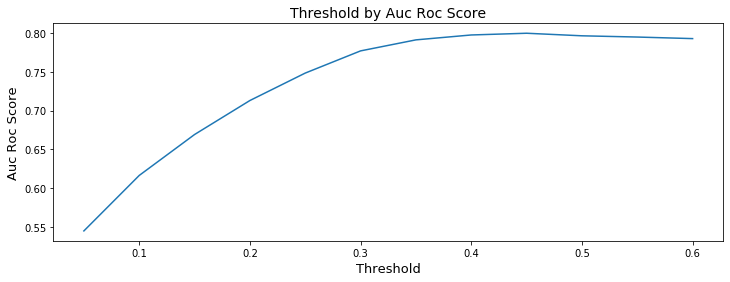

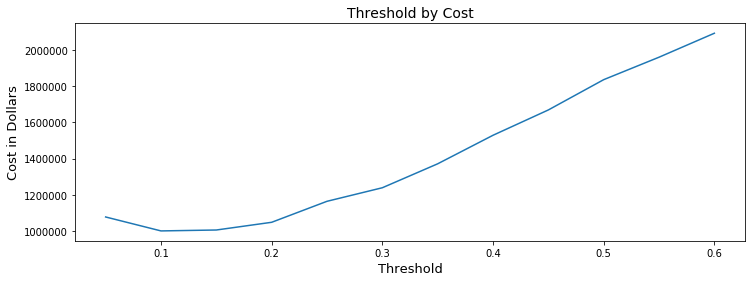

Best threshold by cost: 0.1
Best threshold by roc auc score: 0.45 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.544552     1076780   16  51439
1        0.10       0.616199      999680   51  42334
2        0.15       0.669066     1004720  102  34936
3        0.20       0.712985     1047360  160  28368
4        0.25       0.748422     1163440  240  22172
5        0.30       0.777089     1238360  297  17368
6        0.35       0.791313     1370780  364  13939
7        0.40       0.797643     1528560  434  11328
8        0.45       0.799873     1668620  493   9481
9        0.50       0.796571     1836040  558   8102
10       0.55       0.794964     1960240  607   6962
11       0.60       0.792944     2092760  659   5788

roc auc score: 0.7998729693550642 

              precision    recall  f1-score   support

           0       0.99      0.83      0.90     56945
           1       0.15      0.77      0.24      2109

    accuracy

In [174]:
# testing LogisticRegression
bool_predict_proba = True
model_current =  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                   intercept_scaling=0.1, l1_ratio=0.01, max_iter=100,
                                   multi_class='auto', n_jobs=-1, penalty='none',
                                   random_state=42, solver='newton-cg', tol=1e-06, verbose=0,
                                   warm_start=False)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)

roc auc score: 0.8822342988486682 

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     56945
           1       0.31      0.83      0.45      2109

    accuracy                           0.93     59054
   macro avg       0.65      0.88      0.71     59054
weighted avg       0.97      0.93      0.94     59054


df_scores:

     feat_tested     fn      fp  precision    recall  time_elapsed (min)  \
449         NaN  450.0  8576.0   0.162091  0.78662

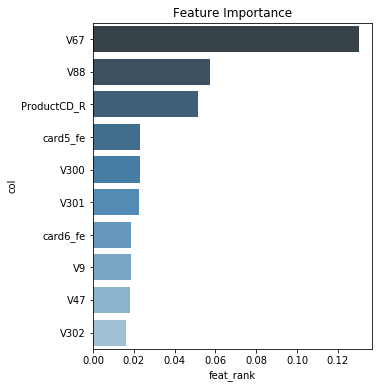

           col  feat_rank
0          V67   0.130213
1          V88   0.057289
2  ProductCD_R   0.051385
3     card5_fe   0.023299
4         V300   0.023171
5         V301   0.022625
6     card6_fe   0.018710
7           V9   0.018521
8          V47   0.018159
9         V302   0.016392


In [172]:
# TESTING XGBClassifier n_estimators=150
bool_predict_proba = False
model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
                              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
                              nthread=None, objective='binary:logistic', random_state=42,
                              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
                              silent=None, subsample=0.5, verbosity=1)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


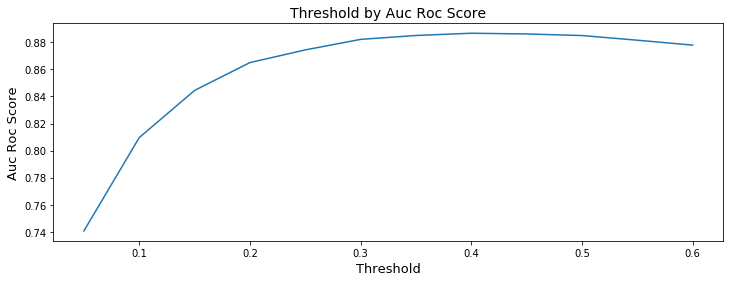

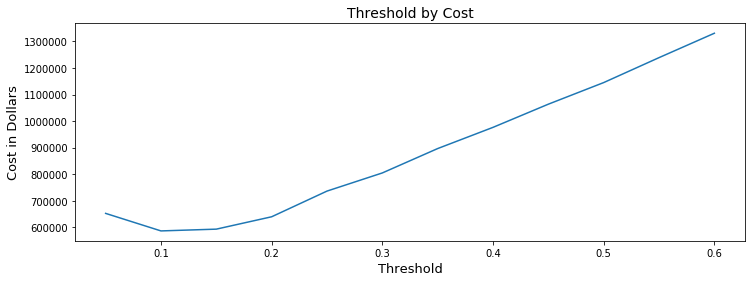

Best threshold by cost: 0.1
Best threshold by roc auc score: 0.4 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.740635      652280   25  28864
1        0.10       0.809579      586260   62  20013
2        0.15       0.844446      592940   97  15097
3        0.20       0.865027      639540  135  11727
4        0.25       0.874395      736280  183   9364
5        0.30       0.882174      804660  218   7533
6        0.35       0.885062      896480  258   6124
7        0.40       0.886713      976360  292   5018
8        0.45       0.886177     1063680  327   4134
9        0.50       0.885018     1145040  359   3402
10       0.55       0.881567     1239000  394   2850
11       0.60       0.877949     1330880  428   2344

roc auc score: 0.886712820190645 

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     56945
           1       0.27      0.86      0.41      2109

    accuracy  

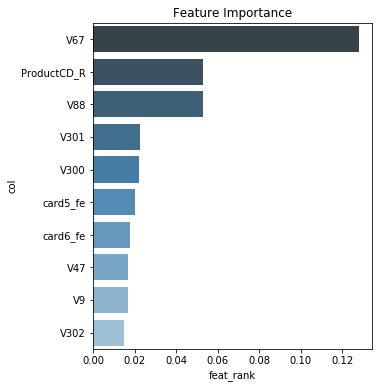

           col  feat_rank
0          V67   0.127891
1  ProductCD_R   0.053158
2          V88   0.053002
3         V301   0.022626
4         V300   0.021941
5     card5_fe   0.020173
6     card6_fe   0.018008
7          V47   0.016993
8           V9   0.016852
9         V302   0.014930


In [175]:
# testing XGBClassifier 200 n_estimators
model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
                              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
                              nthread=None, objective='binary:logistic', random_state=42,
                              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
                              silent=None, subsample=0.5, verbosity=1)
mod.create_df_score_model(model_current)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=9,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=3,
                       min_weight_fraction_leaf=0.3, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


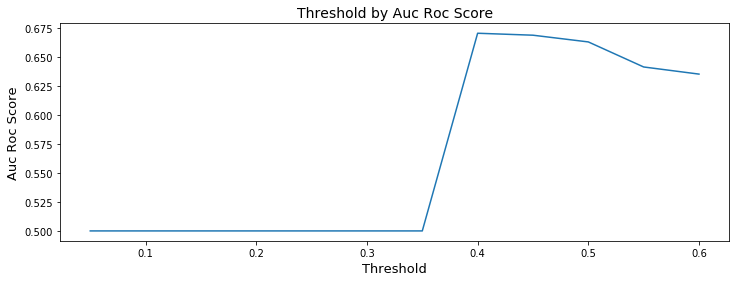

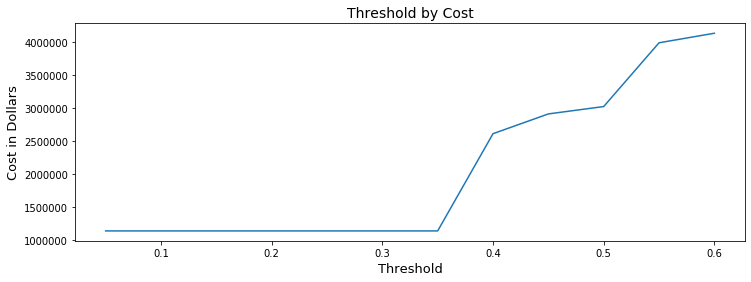

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.4 

threshold results dataframe:
     threshold  roc_auc_score  total_cost    fn     fp
0        0.05       0.500000     1138900     0  56945
1        0.10       0.500000     1138900     0  56945
2        0.15       0.500000     1138900     0  56945
3        0.20       0.500000     1138900     0  56945
4        0.25       0.500000     1138900     0  56945
5        0.30       0.500000     1138900     0  56945
6        0.35       0.500000     1138900     0  56945
7        0.40       0.670816     2609560   756  17078
8        0.45       0.669121     2908620   876  14031
9        0.50       0.663317     3020240   916  13612
10       0.55       0.641670     3984660  1288   6033
11       0.60       0.635506     4129080  1341   5304

roc auc score: 0.6708164287693936 

              precision    recall  f1-score   support

           0       0.98      0.70      0.82     56945
           1       0.07      0.64      0.13      2109


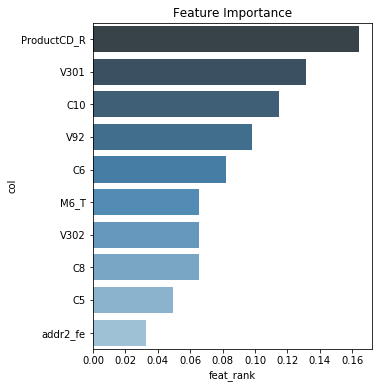

           col  feat_rank
0  ProductCD_R   0.163934
1         V301   0.131148
2          C10   0.114754
3          V92   0.098361
4           C6   0.081967
5         M6_T   0.065574
6         V302   0.065574
7           C8   0.065574
8           C5   0.049180
9     addr2_fe   0.032787


In [176]:
# RETUNE testing RandomForestClassifier
model_current = RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=5, max_features='auto',
                                       max_leaf_nodes=9,
                                       min_impurity_decrease=0.1, min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=3,
                                       min_weight_fraction_leaf=0.3, n_estimators=100,
                                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                                       warm_start=False)
mod.create_df_score_model(model_current)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=9,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=3,
                       min_weight_fraction_leaf=0.3, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


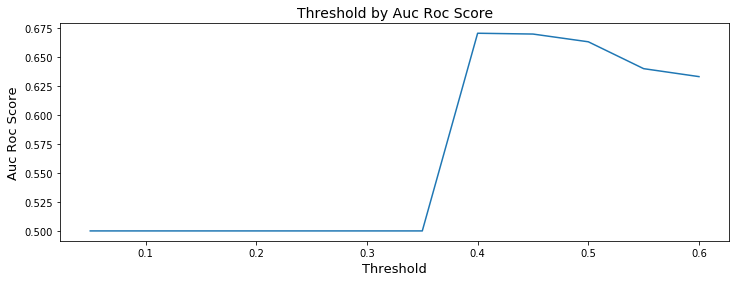

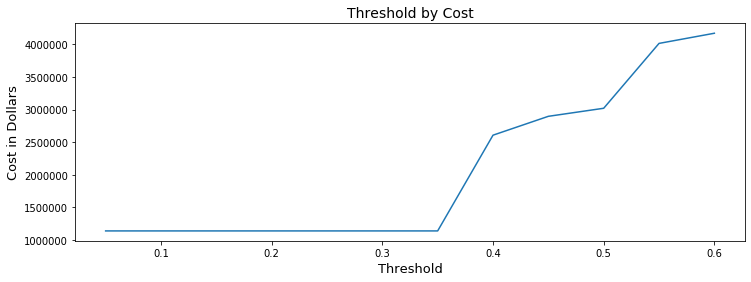

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.4 

threshold results dataframe:
     threshold  roc_auc_score  total_cost    fn     fp
0        0.05       0.500000     1138900     0  56945
1        0.10       0.500000     1138900     0  56945
2        0.15       0.500000     1138900     0  56945
3        0.20       0.500000     1138900     0  56945
4        0.25       0.500000     1138900     0  56945
5        0.30       0.500000     1138900     0  56945
6        0.35       0.500000     1138900     0  56945
7        0.40       0.670667     2607440   755  17122
8        0.45       0.669973     2896840   872  14042
9        0.50       0.663290     3020300   916  13615
10       0.55       0.640089     4015320  1299   5916
11       0.60       0.633214     4171200  1356   5160

roc auc score: 0.6706671702595748 

              precision    recall  f1-score   support

           0       0.98      0.70      0.82     56945
           1       0.07      0.64      0.13      2109


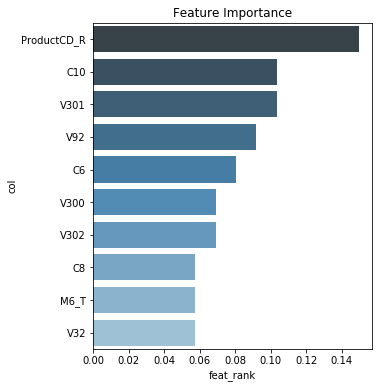

           col  feat_rank
0  ProductCD_R   0.149425
1          C10   0.103448
2         V301   0.103448
3          V92   0.091954
4           C6   0.080460
5         V300   0.068966
6         V302   0.068966
7           C8   0.057471
8         M6_T   0.057471
9          V32   0.057471


In [177]:
# testing RandomForestClassifier n_estimators=150
model_current = RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=5, max_features='auto',
                                       max_leaf_nodes=9,
                                       min_impurity_decrease=0.1, min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=3,
                                       min_weight_fraction_leaf=0.3, n_estimators=150,
                                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                                       warm_start=False)
mod.create_df_score_model(model_current)


Fitting model:
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=5,
                       min_weight_fraction_leaf=0, presort='auto',
                       random_state=42, splitter='best')


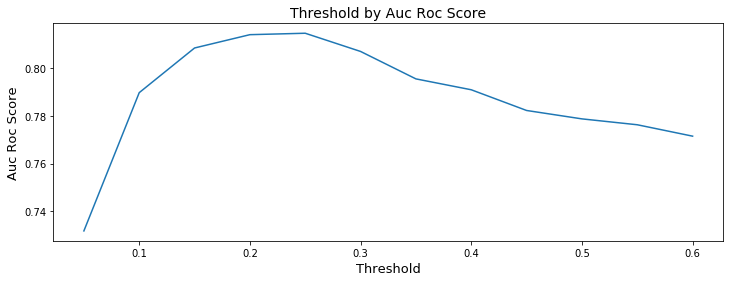

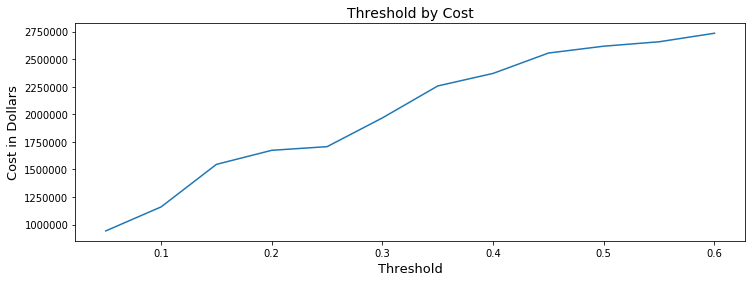

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.731828      942940  135  26897
1        0.10       0.789628     1160600  277  16480
2        0.15       0.808303     1546100  451   9655
3        0.20       0.813869     1673640  508   7482
4        0.25       0.814466     1706720  522   7036
5        0.30       0.806852     1967600  621   5230
6        0.35       0.795384     2256940  728   3647
7        0.40       0.790836     2370620  770   3031
8        0.45       0.782178     2555160  837   2208
9        0.50       0.778665     2617280  859   2014
10       0.55       0.776207     2657320  873   1916
11       0.60       0.771439     2734600  900   1730

roc auc score: 0.8144657562442961 

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     56945
           1       0.18      0.75      0.30      2109

    accurac

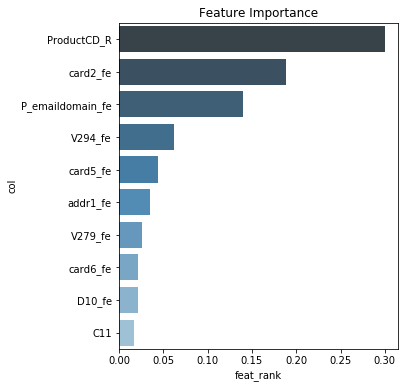

                col  feat_rank
0       ProductCD_R   0.299810
1          card2_fe   0.188458
2  P_emaildomain_fe   0.140255
3           V294_fe   0.061730
4          card5_fe   0.044080
5          addr1_fe   0.035400
6           V279_fe   0.025616
7          card6_fe   0.021235
8            D10_fe   0.021186
9               C11   0.017006


In [178]:
# testing DecisionTreeClassifier max_depth=11
model_current = DecisionTreeClassifier(class_weight='balanced',
                                       criterion='entropy', max_depth=11, max_features=None,
                                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       min_impurity_split=None, min_samples_leaf=9,
                                       min_samples_split=5, min_weight_fraction_leaf=0,
                                       presort='auto', random_state=42, splitter='best')

mod.create_df_score_model(model_current)

Fitting model:
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=5,
                       min_weight_fraction_leaf=0, presort='auto',
                       random_state=42, splitter='best')


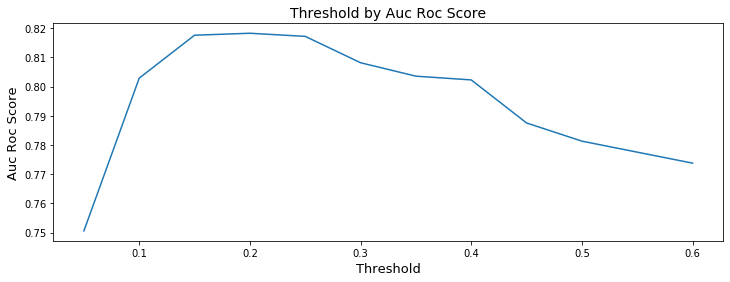

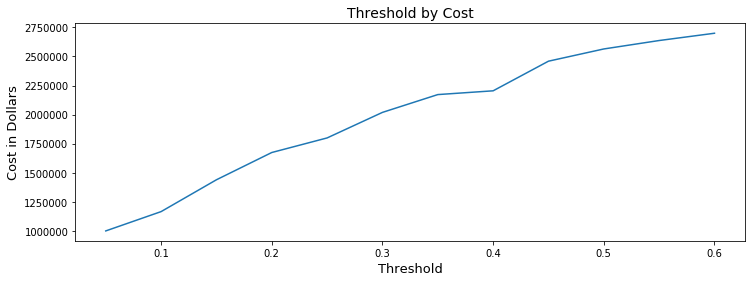

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.750547      998700  175  23685
1        0.10       0.802886     1164840  291  14592
2        0.15       0.817592     1438840  416   9542
3        0.20       0.818268     1673460  512   6873
4        0.25       0.817196     1798900  562   5645
5        0.30       0.808160     2018740  643   4487
6        0.35       0.803559     2171900  701   3445
7        0.40       0.802277     2204340  713   3267
8        0.45       0.787525     2459340  803   2517
9        0.50       0.781300     2564540  840   2227
10       0.55       0.777524     2637100  866   1955
11       0.60       0.773766     2699780  888   1789

roc auc score: 0.8182677536379862 

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     56945
           1       0.19      0.76      0.30      2109

    accuracy

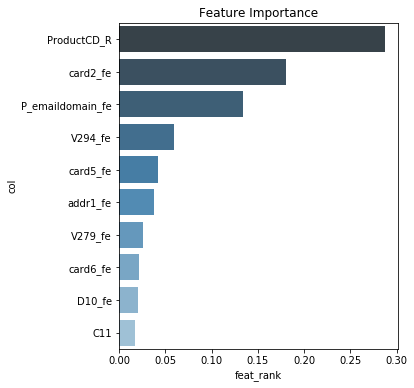

                col  feat_rank
0       ProductCD_R   0.287072
1          card2_fe   0.180950
2  P_emaildomain_fe   0.134429
3           V294_fe   0.059769
4          card5_fe   0.042207
5          addr1_fe   0.037437
6           V279_fe   0.025849
7          card6_fe   0.021462
8            D10_fe   0.020395
9               C11   0.017218


In [179]:
# testing DecisionTreeClassifier max_depth=13
model_current = DecisionTreeClassifier(class_weight='balanced',
                                       criterion='entropy', max_depth=13, max_features=None,
                                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       min_impurity_split=None, min_samples_leaf=9,
                                       min_samples_split=5, min_weight_fraction_leaf=0,
                                       presort='auto', random_state=42, splitter='best')

mod.create_df_score_model(model_current)

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)


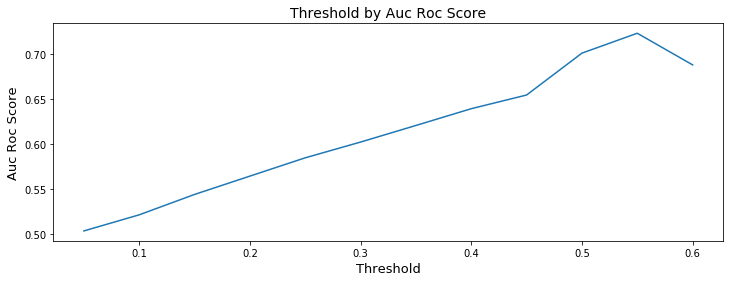

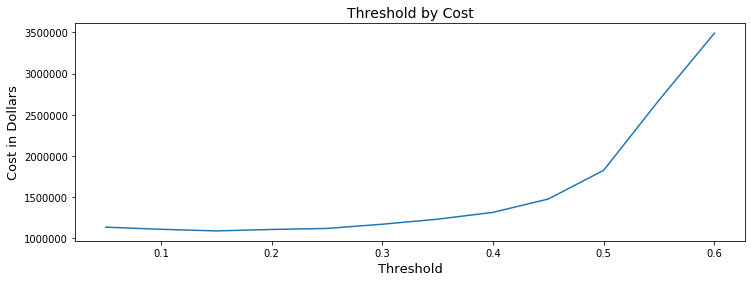

Best threshold by cost: 0.15
Best threshold by roc auc score: 0.55 

threshold results dataframe:
     threshold  roc_auc_score  total_cost    fn     fp
0        0.05       0.503222     1134020     1  56551
1        0.10       0.521117     1108020     7  54351
2        0.15       0.543788     1088360    20  51418
3        0.20       0.564149     1105940    46  48397
4        0.25       0.584502     1118620    70  45431
5        0.30       0.602027     1169720   107  42436
6        0.35       0.620466     1231040   149  39202
7        0.40       0.639115     1314020   200  35701
8        0.45       0.654331     1476160   280  31808
9        0.50       0.700883     1825220   465  21511
10       0.55       0.723007     2677640   832   9082
11       0.60       0.687839     3490820  1130   5041

roc auc score: 0.7230065062821508 

              precision    recall  f1-score   support

           0       0.98      0.84      0.91     56945
           1       0.12      0.61      0.20      2109

In [180]:
# base score LogisticRegression threshold
bool_predict_proba = True
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)
bool_predict_proba = False


In [181]:
# base model LogisticRegression
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

roc auc score: 0.7008829487463073 

              precision    recall  f1-score   support

           0       0.99      0.62      0.76     56945
           1       0.07      0.78      0.13      2109

    accuracy                           0.63     59054
   macro avg       0.53      0.70      0.45     59054
weighted avg       0.95      0.63      0.74     59054


df_scores:

     feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
458         NaN  755.0  17122.0   0.073284  0.642010            0.216258   
459         NaN  522.0   7036.0   0.184043  0.752489            1.000709   
460         NaN  512.0   6873.0   0.188548  0.757231            1.200053   


Fitting model:
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

roc auc score: 0.8050608048052489 

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     56945
           1       0.25      0.69      0.36      2109

    accuracy                           0.91     59054
   macro avg       0.62      0.81      0.66     59054
weighted avg       0.96      0.91      0.93     59054


df_scores:

     feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
459         NaN  522.0   7036.0   0.184043  0.752489            1.000709   
460         NaN  512.0   6873.0   0.188548  0.75723

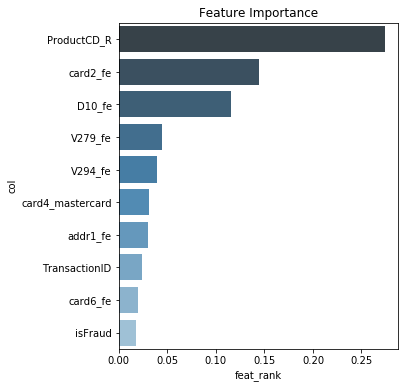

                col  feat_rank
0       ProductCD_R   0.273739
1          card2_fe   0.143984
2            D10_fe   0.115350
3           V279_fe   0.044271
4           V294_fe   0.038829
5  card4_mastercard   0.031173
6          addr1_fe   0.029698
7     TransactionID   0.023893
8          card6_fe   0.019579
9           isFraud   0.018191


In [182]:
# base DecisionTreeClassifier
bool_predict_proba = False
model_current = DecisionTreeClassifier(random_state=42)
mod.create_df_score_model(model_current)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

roc auc score: 0.7977015538397482 

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     56945
           1       0.54      0.61      0.57      2109

    accuracy                           0.97     59054
   macro avg       0.76      0.80      0.78     59054
weighted avg       0.97      0.97      0.97     59054


df_scores:

     feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
460         NaN  512.0   6873.0   0.1885

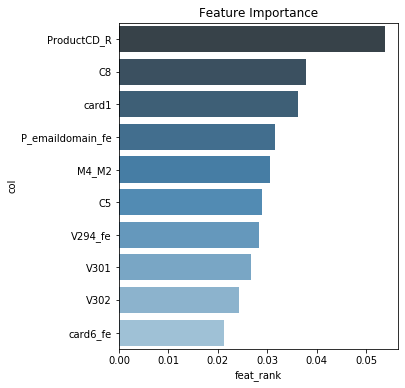

                col  feat_rank
0       ProductCD_R   0.053765
1                C8   0.037947
2             card1   0.036324
3  P_emaildomain_fe   0.031486
4             M4_M2   0.030508
5                C5   0.028868
6           V294_fe   0.028316
7              V301   0.026811
8              V302   0.024247
9          card6_fe   0.021173


In [183]:
# base RandomForestClassifier
bool_predict_proba = False
model_current = RandomForestClassifier(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


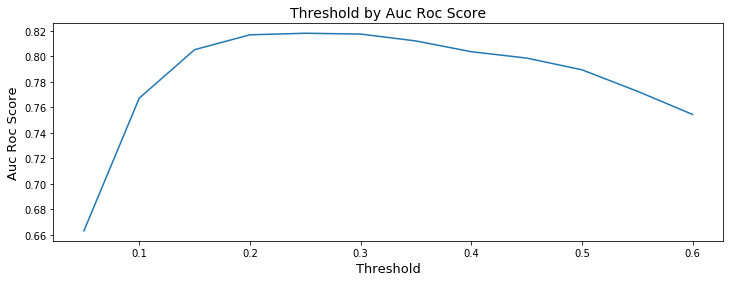

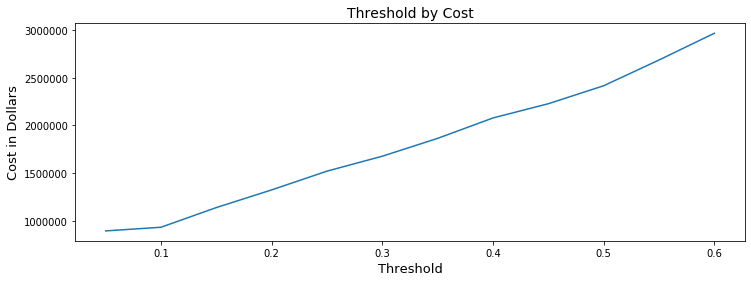

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.25 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.662981      895580   52  36979
1        0.10       0.767072      934000  164  22100
2        0.15       0.805125     1140060  283  14553
3        0.20       0.816776     1325080  369  10904
4        0.25       0.818014     1521520  450   8576
5        0.30       0.817381     1677940  513   6947
6        0.35       0.811963     1864940  584   5647
7        0.40       0.803533     2078480  663   4474
8        0.45       0.798545     2227600  719   3530
9        0.50       0.789352     2415820  787   2741
10       0.55       0.772554     2685320  881   2116
11       0.60       0.754307     2965500  978   1575

roc auc score: 0.8180136382251997 

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     56945
           1       0.16      0.79      0.27      2109

    accurac

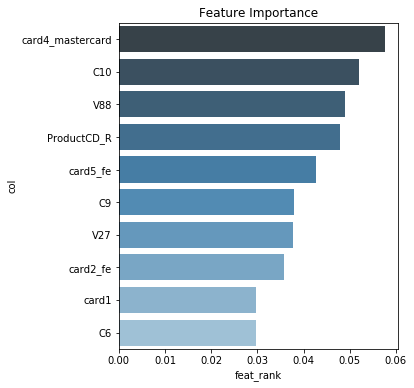

                col  feat_rank
0  card4_mastercard   0.057539
1               C10   0.052076
2               V88   0.049037
3       ProductCD_R   0.047800
4          card5_fe   0.042624
5                C9   0.038017
6               V27   0.037632
7          card2_fe   0.035820
8             card1   0.029793
9                C6   0.029679


In [184]:
# base XGBClassifier threshold
bool_predict_proba = True
model_current = XGBClassifier(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

roc auc score: 0.7893515995673663 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     56945
           1       0.33      0.63      0.43      2109

    accuracy                           0.94     59054
   macro avg       0.66      0.79      0.70     59054
weighted avg       0.96      0.94      0.95     59054


df_scores:

     feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
462         NaN  465.0  21511.0   0.071000  0.779516      

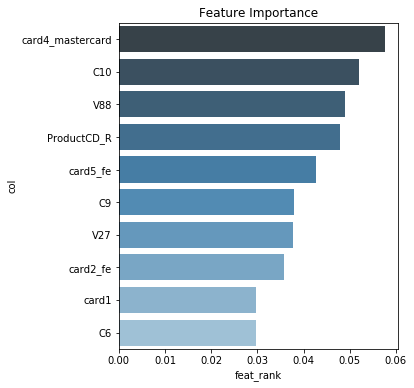

                col  feat_rank
0  card4_mastercard   0.057539
1               C10   0.052076
2               V88   0.049037
3       ProductCD_R   0.047800
4          card5_fe   0.042624
5                C9   0.038017
6               V27   0.037632
7          card2_fe   0.035820
8             card1   0.029793
9                C6   0.029679


In [185]:
# base XGBClassifier
bool_predict_proba = False
model_current = XGBClassifier(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:


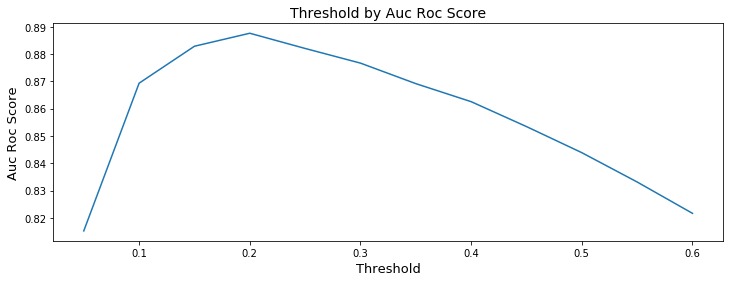

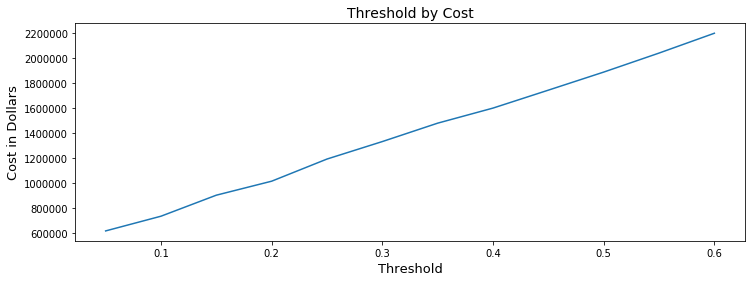

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.815242      615180   79  18909
1        0.10       0.869311      733100  177  10105
2        0.15       0.882832      901560  258   6378
3        0.20       0.887591     1013720  308   4486
4        0.25       0.882023     1191220  375   3311
5        0.30       0.876658     1331360  427   2518
6        0.35       0.869150     1478840  480   1942
7        0.40       0.862547     1599660  523   1533
8        0.45       0.853433     1743420  573   1221
9        0.50       0.843879     1888180  623    959
10       0.55       0.833149     2040540  675    777
11       0.60       0.821673     2199520  729    626

roc auc score: 0.8875907271792498 

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     56945
           1       0.29      0.85      0.43      2109

    accuracy

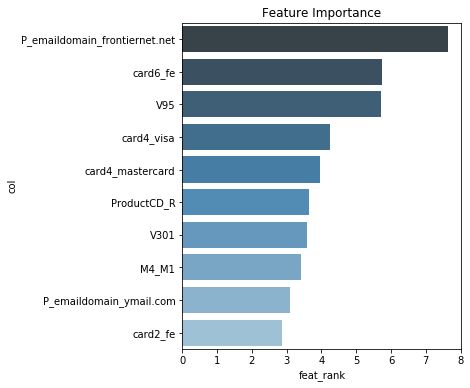

                             col  feat_rank
0  P_emaildomain_frontiernet.net   7.641618
1                       card6_fe   5.739759
2                            V95   5.717950
3                     card4_visa   4.234065
4               card4_mastercard   3.955129
5                    ProductCD_R   3.644143
6                           V301   3.593969
7                          M4_M1   3.401293
8        P_emaildomain_ymail.com   3.090221
9                       card2_fe   2.859790


In [186]:
# predict_proba CatBoostClassifier
bool_predict_proba = True
model_current = CatBoostClassifier(random_state=42, verbose=0)
mod.create_df_score_model(model_current)

Fitting model:


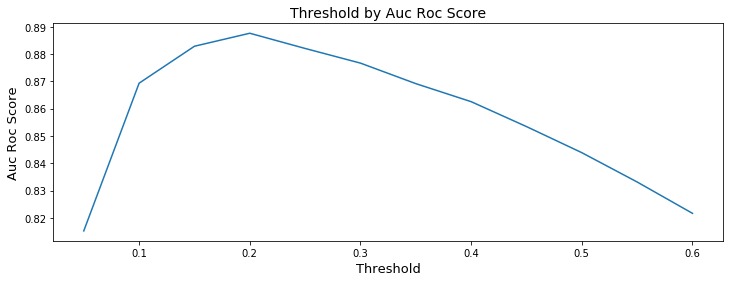

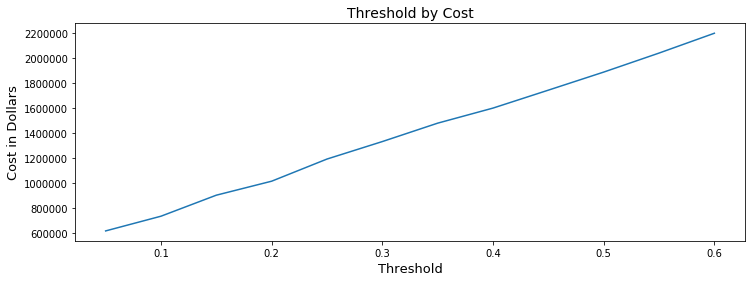

Best threshold by cost: 0.05
Best threshold by roc auc score: 0.2 

threshold results dataframe:
     threshold  roc_auc_score  total_cost   fn     fp
0        0.05       0.815242      615180   79  18909
1        0.10       0.869311      733100  177  10105
2        0.15       0.882832      901560  258   6378
3        0.20       0.887591     1013720  308   4486
4        0.25       0.882023     1191220  375   3311
5        0.30       0.876658     1331360  427   2518
6        0.35       0.869150     1478840  480   1942
7        0.40       0.862547     1599660  523   1533
8        0.45       0.853433     1743420  573   1221
9        0.50       0.843879     1888180  623    959
10       0.55       0.833149     2040540  675    777
11       0.60       0.821673     2199520  729    626

roc auc score: 0.8875907271792498 

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     56945
           1       0.29      0.85      0.43      2109

    accuracy

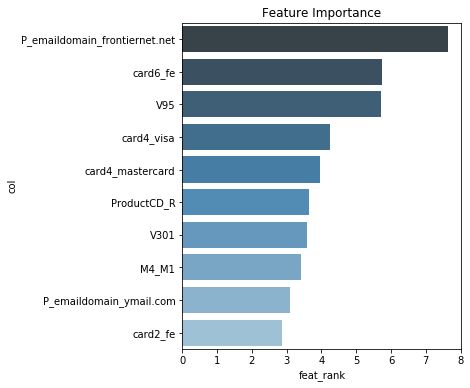

                             col  feat_rank
0  P_emaildomain_frontiernet.net   7.641618
1                       card6_fe   5.739759
2                            V95   5.717950
3                     card4_visa   4.234065
4               card4_mastercard   3.955129
5                    ProductCD_R   3.644143
6                           V301   3.593969
7                          M4_M1   3.401293
8        P_emaildomain_ymail.com   3.090221
9                       card2_fe   2.859790


In [187]:
# base CatBoostClassifier
model_current = CatBoostClassifier(random_state=42, verbose=0)
mod.create_df_score_model(model_current)

In [188]:
# bool_predict_proba = True
# model_current = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
#                    intercept_scaling=0.1, l1_ratio=1e-06, max_iter=150,
#                    multi_class='multinomial', n_jobs=-1, penalty='none',
#                    random_state=42, solver='lbfgs', tol=1e-05, verbose=0,
#                    warm_start=False)
# mod.create_df_score_model(model_current)
# bool_predict_proba = False

In [6]:
# # newly tuned LR
# bool_predict_proba = True
# model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
#               colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
#               learning_rate=0.1, max_delta_step=0, max_depth=13,
#               min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
#               nthread=None, objective='binary:logistic', random_state=42,
#               reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
#               silent=None, subsample=0.5, verbosity=1)
# mod.create_df_score_model(model_current)
# bool_predict_proba = False

In [7]:
# bool_predict_proba = True
# model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
#               colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
#               learning_rate=0.1, max_delta_step=0, max_depth=13,
#               min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
#               nthread=None, objective='binary:logistic', random_state=42,
#               reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
#               silent=None, subsample=0.5, verbosity=1)
# mod.create_df_score_model(model_current)
# bool_predict_proba = False

# Model Class

In [165]:
class Model():
    def __init__(self):
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        self.dict_results = {'index':[0], 'threshold':[], 'roc_auc_score':[], 
                             'total_cost':[], 'fn':[], 'fp':[]}
        
        self.X_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv').drop('Unnamed: 0',axis=1)
        self.y_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv').drop('Unnamed: 0',axis=1)
        self.X_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv').drop('Unnamed: 0',axis=1)
        self.y_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv').drop('Unnamed: 0',axis=1)
        self.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0',axis=1)
        self.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0',axis=1)
        
    def create_df_score_model(self, model_current):
        '''scores model'''
        print("Fitting model:\n", model_current)
        y_pred, elapsed_time = self.add_model(model_current) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model_current)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred = self._predict(model)
        bool_predict_proba = False
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            y_pred = self._predict_proba(model)
            y_pred = self._predict_proba_threshold(y_pred)
            return y_pred 
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred
        
    def _predict_proba(self, model):
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            return y_pred_prob
        except:
            print("Model does not have predict_proba attribute.")

    def _predict_proba_threshold(self, y_pred):
        '''create prediction for each threshold'''
        df_results = pd.DataFrame()
        list_threshold = [.05, .1, .15, .2, .25, .3, 
                          .35, .4, .45, .5, .55, .6]
        for threshold in list_threshold:
            df_temp = self._compute_thres_df(y_pred, threshold)
            df_results = pd.concat([df_results, df_temp], axis=0)
        df_results = df_results.drop('index', axis=1).reset_index(drop=True)
        val_thres_cost, val_thres_auc = self._calc_and_plot_results(df_results)
        y_pred_class = self._y_pred_class(y_pred, val_thres_cost, val_thres_auc)
        print('threshold results dataframe:\n', df_results)
        return y_pred_class
        
    def _compute_thres_df(self, y_pred_prob, threshold):
        '''compute the values for each threshold'''
        y_pred_class = binarize(y_pred_prob, threshold)[:,1]
        df_conf_matrix = self._compute_conf_matrix(y_pred_class)
        df_dict_results = self._compute_results(df_conf_matrix, y_pred_class, threshold)
        return df_dict_results
    
    def _compute_conf_matrix(self, y_pred_class):
        '''compute the confusion matrix for the current threshold'''
        conf_matr = confusion_matrix(self.y_test, y_pred_class)
        df_conf_matrix = pd.DataFrame(conf_matr)
        return df_conf_matrix
    
    def _compute_results(self, df_conf_matrix, y_pred_class, threshold):
        '''compute results for each threshold and save to dictionary'''
        val_fn = df_conf_matrix[0][1]
        val_fp = df_conf_matrix[1][0]
        val_cost = 3000*val_fn + 20*val_fp
        val_score = roc_auc_score(self.y_test, y_pred_class)
        self.dict_results.update([('threshold', threshold)])
        self.dict_results.update([('roc_auc_score', val_score)])
        self.dict_results.update([('total_cost', val_cost)])
        self.dict_results.update([('fn', val_fn)])
        self.dict_results.update([('fp', val_fp)])
        df_dict_results = pd.DataFrame.from_dict(self.dict_results)
        return df_dict_results
    
    def _calc_and_plot_results(self, df_results):
        '''plot results and calculate best threshold for auc and cost'''
        self._plot_thres_auc(df_results)
        self._plot_thres_score(df_results)
        val_thres_cost = self._calc_best_thres_cost(df_results)
        val_thres_auc = self._calc_best_thres_auc(df_results)
        return val_thres_cost, val_thres_auc
        
    def _plot_thres_auc(self, df_results):
        '''plot auc roc score by threshold'''
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Auc Roc Score", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Auc Roc Score", fontsize=13)
        plt.plot('threshold', 'roc_auc_score', data=df_results)
        plt.show()

    def _plot_thres_score(self, df_results):
        '''plot cost by threshold'''
        plt.figure(figsize=(12,4))
        plt.title("Threshold by Cost", fontsize=14)
        plt.xlabel('Threshold', fontsize=13)
        plt.ylabel("Cost in Dollars", fontsize=13)
        plt.plot('threshold', 'total_cost', data=df_results)
        plt.show()
    
    def _calc_best_thres_cost(self, df_results):
        '''calculate the best threshold by cost'''
        val_min_cost = df_results.total_cost.min()
        index_min_cost = df_results[df_results.total_cost==val_min_cost].index[0]
        val_threshold_min_cost = df_results.loc[index_min_cost,:].threshold.item()
        print("Best threshold by cost:", val_threshold_min_cost)
        return val_threshold_min_cost

    def _calc_best_thres_auc(self, df_results):
        '''calculate the best threshold by highest auc roc score'''
        val_max_roc_auc = df_results.roc_auc_score.max()
        index_max_roc_auc = df_results[df_results.roc_auc_score==val_max_roc_auc].index[0]
        val_threshold_roc_auc = df_results.loc[index_max_roc_auc,:].threshold.item()
        print("Best threshold by roc auc score:", val_threshold_roc_auc, '\n')
        return val_threshold_roc_auc
    
    def _y_pred_class(self, y_pred_prob, val_thres_cost, val_thres_auc):
        '''calculate y_pred_class depending on if we want cost or auc threshold'''
        if bool_thres_cost:
            y_pred_class = binarize(y_pred_prob, val_thres_cost)[:,1]
            return y_pred_class
        else:
            y_pred_class = binarize(y_pred_prob, val_thres_auc)[:,1]
            return y_pred_class

    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time = self._calc_scores(y_pred, elapsed_time)        
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_recall, col_precision, df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print('\nroc auc score:', roc_auc_score(mod.y_test, y_pred), '\n')
        return col_recall, col_precision, col_time
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:", fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print(classif_report)
        print('\ndf_scores:\n\n', df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            df_feat_rank = self._feat_import_create_df(model)
            self._feat_import_create_plot(df_feat_rank)
            print(df_feat_rank[0:10].reset_index(drop=True))
        except:
            print("\nmodel does not have _feature_importance attribute.")
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(fe.df_feat.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        plt.figure(figsize=(5,6))
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        
mod = Model()

## Model Tuning

In [18]:
### Tuning XGBClassifier READY ###
print('tuning xgbc')
xgbc = XGBClassifier(n_jobs=-1, random_state=42)

max_depth = [2,3,5,7,9,11,13]
# learning_rate = [0,.1,.3,.5,.7,.9]
booster = ['gbtree', 'gblinear', 'dart']
subsample = [.1,.3,.5,.7]
colsample_bytree = [.1,.3,.5,.7]
colsample_bylevel = [0,.1,.3,.5,.7,.9,1]
colsample_bynode = [.1,.3,.5,.7]
reg_alpha = [0,1,3,5,7]
reg_lambda = [1,3,5,7]
scale_pos_weight = [1,3,5,7]
base_score = [.1,.2,.3,.4,.5]

hyperparameters = dict(max_depth=max_depth, 
#                        learning_rate=learning_rate, 
                       booster=booster, 
                       subsample=subsample, 
                       colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, 
                       colsample_bynode=colsample_bynode, reg_alpha=reg_alpha, reg_lambda=reg_lambda, 
                       scale_pos_weight=scale_pos_weight,
                       base_score=base_score
                      )

clf = RandomizedSearchCV(xgbc, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best booster:', best_model.best_estimator_.get_params()['booster'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print('Best colsample_bytree:', best_model.best_estimator_.get_params()['colsample_bytree'])
print('Best colsample_bylevel:', best_model.best_estimator_.get_params()['colsample_bylevel'])
print('Best colsample_bynode:', best_model.best_estimator_.get_params()['colsample_bynode'])
print('Best reg_alpha:', best_model.best_estimator_.get_params()['reg_alpha'])
print('Best reg_lambda:', best_model.best_estimator_.get_params()['reg_lambda'])
print('Best scale_pos_weight:', best_model.best_estimator_.get_params()['scale_pos_weight'])
print('Best base_score:', best_model.best_estimator_.get_params()['base_score'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


tuning xgbc
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 7.5min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.986, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.3min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.985, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 28.2min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.0min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.2min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.988, total= 6.2min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 40.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.3min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 46.7min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.3min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 53.0min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.4min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 59.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.988, total= 6.6min
[CV] subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4 
[CV]  subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4, score=0.966, total= 2.6min
[CV] subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4 
[CV]  subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4, score=0.964, total= 2.6min
[CV] subsample=0.7, scale_pos_weigh

[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.796, total= 1.6min
[CV] subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5 
[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.804, total= 1.6min
[CV] subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5 
[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.802, total= 1.7min
[CV] subsample=0.5, s

[CV]  subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3, score=0.984, total= 2.4min
[CV] subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3 
[CV]  subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3, score=0.986, total=14.8min
[CV] subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3 
[CV]  subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3, score=0.987, total= 2.6min
[CV] subsample=0.7, s

[CV]  subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1, score=0.987, total= 4.3min
[CV] subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1 
[CV]  subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1, score=0.986, total= 4.4min
[CV] subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1 
[CV]  subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1, score=0.987, total= 4.5min
[CV] subsample=0.1, scale_pos_weight

[CV]  subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3, score=0.984, total= 2.8min
[CV] subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3 
[CV]  subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3, score=0.983, total= 2.8min
[CV] subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3 
[CV]  subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3, score=0.984, total= 2.8min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 315.8min finished


Best max_depth: 13
Best learning_rate: 0.1
Best booster: gbtree
Best subsample: 0.5
Best colsample_bytree: 0.7
Best colsample_bylevel: 0.3
Best colsample_bynode: 0.5
Best reg_alpha: 3
Best reg_lambda: 5
Best scale_pos_weight: 5
Best base_score: 0.4


In [19]:
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)

XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_reg_lambda,param_reg_alpha,param_max_depth,param_colsample_bytree,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,395.304133,25.412146,0.587299,0.052609,0.5,3,5,5,9,0.5,...,0.985380,0.986789,0.987938,0.986694,0.987347,0.986711,0.987547,0.986829,0.000743,2
1,167.217239,11.165350,0.489047,0.155241,0.7,1,7,7,11,0.7,...,0.963229,0.964751,0.967276,0.963401,0.966066,0.964305,0.966658,0.965024,0.001343,7
2,120.322799,8.478442,0.271042,0.108111,0.1,7,3,7,2,0.7,...,0.961926,0.962940,0.965645,0.961338,0.963113,0.962412,0.964037,0.963005,0.001308,8
3,99.684576,5.295310,0.226211,0.090092,0.5,7,1,5,9,0.7,...,0.802181,0.798554,0.805074,0.801674,0.804025,0.797907,0.806804,0.801659,0.003228,10
4,203.073417,25.312860,0.677408,0.173201,0.5,5,5,3,13,0.7,...,0.987628,0.988995,0.989606,0.988777,0.989180,0.988744,0.989257,0.988861,0.000556,1
5,217.663624,223.572931,0.553119,0.219257,0.7,3,1,7,9,0.7,...,0.984488,0.985504,0.986885,0.985129,0.985695,0.984936,0.986337,0.985598,0.000679,4
6,103.800450,5.746303,0.394553,0.301245,0.1,7,7,3,3,0.3,...,0.959114,0.960575,0.963978,0.959773,0.963111,0.959996,0.962418,0.961344,0.001475,9
7,305.320971,59.342621,0.606575,0.120821,0.1,3,3,0,13,0.5,...,0.985453,0.986445,0.987005,0.985547,0.986576,0.985673,0.987112,0.986233,0.000623,3
8,102.538558,3.363380,0.421863,0.036955,0.5,3,5,7,11,0.1,...,0.982312,0.983491,0.984753,0.982607,0.983767,0.982724,0.984011,0.983344,0.000777,5
9,173.911546,5.071884,0.338486,0.032476,0.3,5,7,5,7,0.3,...,0.982008,0.983266,0.984789,0.982414,0.983546,0.982560,0.983857,0.983167,0.000871,6


In [ ]:
###### testing manual tuning ######
### manual xbgc tuning
max_depth = [3,5,7,9,11,13,15]
# max_depth = [1,3,5]
list_time_elapsed = []
list_roc_auc_score = []
for val in max_depth:
    model_xgbc = XGBClassifier(max_depth=val, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    model_xgbc.fit(mod.X_train_test, mod.y_train)
    y_pred_xgbc = model_xgbc.predict(mod.X_test)
    elapsed_time = (time.time() - start_time) / 60
    
    score_roc_auc = roc_auc_score(mod.y_test, y_pred_xgbc)

    list_time_elapsed.append(elapsed_time)
    list_roc_auc_score.append(score_roc_auc)
    print('max depth: ', val)
    print(confusion_matrix(mod.y_test, y_pred_xgbc))

col_time_elapsed = pd.Series(list_time_elapsed)
col_roc_score = pd.Series(list_roc_auc_score)
col_max_depth = pd.Series(max_depth)
df_results_xgbc = pd.concat([col_max_depth, col_roc_score,col_time_elapsed], 
                            keys=['max_depth', 'roc_auc_score', 'time_elap'], 
                            axis=1)
print(df_results_xgbc)

sns.lineplot(x='max_depth', y='roc_auc_score', data=df_results_xgbc)
plt.title("XGBC manual tuning")
plt.show()

In [ ]:
#### Tuning RandomForestClassifier READY ####
rfc = RandomForestClassifier(oob_score=False, n_jobs=1, random_state=42, verbose=1)

n_estimators = [50,75,100,125,150,200]
criterion = ['gini', 'entropy']
max_depth = [3,5,7,9,11,13,15]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,2,4,6,8,10]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [2,3,5,7,9,None]
min_impurity_decrease = [0,.1,.3,.5,.7,.9]

hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                       min_impurity_decrease=min_impurity_decrease
                      )

clf = RandomizedSearchCV(rfc, hyperparameters, random_state=42, cv=5, verbose=5, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes'])
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [191]:
#### LR Tuning ####
lr = LogisticRegression(random_state=42, n_jobs=-1)

penalty = ['l1', 'l2', 'elasticnet','none']
tol = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
C = [1e-1,.2,.3,.5,.7,1]
fit_intercept = [True,False]
intercept_scaling = [1,.1,.01,.001]
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'sag']#, 'liblinear','saga']
max_iter = [50,75,100,150,200]
multi_class = ['auto', 'ovr', 'multinomial']
l1_ratio = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]


hyperparameters = dict(penalty=penalty, 
#                        tol=tol, 
#                        C=C, 
#                        fit_intercept=fit_intercept,
                       intercept_scaling=intercept_scaling, 
                       class_weight=class_weight,
                       solver=solver, 
#                        max_iter=max_iter
                       multi_class=multi_class, 
                       l1_ratio=l1_ratio
                      )

clf = RandomizedSearchCV(lr, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)
# best_model = clf.fit(mod.X_features_test, mod.y_target_test) #testing

# best hyper parameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best tol:', best_model.best_estimator_.get_params()['tol'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best fit_intercept:', best_model.best_estimator_.get_params()['fit_intercept'])
print('Best intercept_scaling:', best_model.best_estimator_.get_params()['intercept_scaling'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Best multi_class:', best_model.best_estimator_.get_params()['multi_class'])
print('Best l1_ratio:', best_model.best_estimator_.get_params()['l1_ratio'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [ ]:
#### Tuning DTC READY ####
dt = DecisionTreeClassifier(random_state=42, n_jobs=-1)

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3,5,7,9,11]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,3,5,7,9]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
class_weight = ['balanced', None]

hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, 
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, class_weight=class_weight
                      )

clf = RandomizedSearchCV(dt, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)
# best_model = clf.fit(mod.X_features_test, mod.y_target_test) #testing
 
# best hyper parameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [ ]:
### Tuning CatBoost READY ###
# Tune learning rate manually.
cbc = CatBoostClassifier(random_state=42)

max_depth = [2,3,5,7,9,11,13]
learning_rate = [.1,.3,.5,.7,.9]
# bagging_temperature = []
subsample = [1,3,5,7]
n_estimators = [50,75,100,150]
depth = [2,4,6,8,10]
grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']


hyperparameters = dict(max_depth=max_depth, 
#                        learning_rate=learning_rate, 
#                        n_estimators=n_estimators,
                       subsample=subsample,
#                        depth=depth,
                       grow_policy=grow_policy
                      )

clf = RandomizedSearchCV(cbc, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)



In [189]:
df_temp_read = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
df_temp_read = df_temp_read.drop('Unnamed: 0', axis=1)
df_temp_read[len(df_temp_read)-40:]

,feat_tested,fn,fp,precision,recall,time_elapsed (min),tn,tp
429,NaN,832.0,9082.0,0.123274,0.605500,0.885854,1277.0,47863.0
430,NaN,437.0,31562.0,0.050310,0.792793,0.969671,1672.0,25383.0
431,NaN,493.0,9481.0,0.145625,0.766240,33.358289,1616.0,47464.0
432,NaN,437.0,31562.0,0.050310,0.792793,1.004172,1672.0,25383.0
433,NaN,319.0,5546.0,0.244002,0.848743,3.416962,1790.0,51399.0
434,NaN,787.0,2741.0,0.325375,0.626837,4.003713,1322.0,54204.0
435,NaN,450.0,8576.0,0.162091,0.786629,3.838663,1659.0,48369.0
436,NaN,354.0,3854.0,0.312890,0.832148,4.621600,1755.0,53091.0
437,NaN,522.0,7036.0,0.184043,0.752489,0.725779,1587.0,49909.0
438,NaN,437.0,31562.0,0.050310,0.792793,1.062953,1672.0,25383.0
